<a href="https://colab.research.google.com/github/anik314159/Hate-Alert-Urdu-Sentiment-Analysis-project-/blob/main/Urdu_Hate_Alert_Task_B_pt2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np 
import torch.nn as nn
import torch 
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')


In [ ]:
trainData = pd.read_csv('/content/drive/MyDrive/urdu_hate_task_B/Training Dataset.csv')
trainData.drop(['label'],axis = 1,inplace = True)

In [ ]:
trainData

,Tweets,S/G
0,بکواس مت کرو,1
1,تمہاری ہیجڑا فورس ایک نہتے کے سامنے بکری بنی ہ...,0
2,آفیسر سمیتبھارتی فوجی جہنم واصل،بنکرز تباہ بھا...,1
3,غدار منافق میر اللہ تمہیں زلیل کرے,1
4,اگست پر آپ بھارت کو کیا پیغام دینا چاہیں گے؟ م...,0
...,...,...
3559,ارے شعر ہے حقیقت میں کہیں پیچھے نا پڑنا ۔,2
3560,ہندوستانی باوردی غنڈا ایل او سی پر پتھر مار کے...,2
3561,یہ خبر افسوس ناک ھے,2
3562,جناب محترم سلمان وفادارصاھب کیا پارلیمنٹ آئینی...,2


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 4.6 MB/s 
     |████████████████████████████████| 120 kB 55.8 MB/s 
     |████████████████████████████████| 6.6 MB 45.8 MB/s 


In [ ]:
from transformers import BertConfig,BertForSequenceClassification,BertModel
from transformers import *

from transformers import BertTokenizer
Paths_to_transformers = { 'muril': 'google/muril-base-cased',
                         'mbert': 'bert-base-multilingual-cased'}
tokenizer = BertTokenizer.from_pretrained(Paths_to_transformers['mbert'])

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bert-base-multilingual-cased/snapshots/cf732291d5a8eace7b973ccd13c95ec07b19e734/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--bert-base-multilingual-cased/snapshots/cf732291d5a8eace7b973ccd13c95ec07b19e734/tokenizer_config.json


Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-multilingual-cased/snapshots/cf732291d5a8eace7b973ccd13c95ec07b19e734/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-multilingual-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size":

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
  def __init__(self,df,max_len,tokenizer):
    self.df = df
    self.max_len = max_len
    self.tokenizer = tokenizer
    self.label = self.df['S/G']
    self.title = self.df['Tweets']
    
  def __len__(self):
    return len(self.title)

  def __getitem__(self,index):
    text = self.title.iloc[index]
    text = " ".join(text.split())
    inputs = self.tokenizer.encode_plus(text,add_special_tokens = True,
                                  max_length=self.max_len,
                                  padding = 'max_length',
                                  return_token_type_ids = True,
                                  truncation = True,
                                  return_attention_mask = True,
                                  return_tensors = 'pt')
    
    tens = []
    tens.append(0)
    tens.append(0)
    tens.append(0)

    tens[self.label.iloc[index]] = 1;
    
    return {
        'input_ids': inputs['input_ids'].flatten(),
        'attention_mask':inputs['attention_mask'].flatten(),
        'token_type_ids':inputs['token_type_ids'].flatten(),
        'labels': torch.FloatTensor(tens)
        
    }


In [ ]:
train_df,val_df = train_test_split(trainData,test_size = 0.2,random_state= 2020)
train_df

,Tweets,S/G
2177,بھارت کے ایٹمی ہتھیار فاشسٹ مودی حکومت کے ہاتھ...,2
95,انشاءاللہ کتے کی موت مریں گے۔,0
3286,سرینگر بھارتی فوج کی دہشت گردی کا سلسلہ جاری۔,2
3000,دل خون کے آنسو رو رہا ہے۔ مسلمان امہ کی بے بسی...,2
2390,ان بےشرم بےغیرتوں کو دیکھو کھانا کیسے ٹھونس رہ...,2
...,...,...
2139,فائیو جی ٹیکنالوجی خطرناک ہے؟,2
2678,کچھ قصاٸی صرف بکرے کی نہیں ہماری کھال اتار لین...,2
3395,آرمی چیف کو توسیع دینے سے ایک بات ضرور ثابت ہو...,2
392,اک بات بتاؤ اگر کویی تمہاری گانڈ مار دے تو تم ...,0


In [ ]:
train_data = CustomDataset(train_df,128,tokenizer)
val_data = CustomDataset(val_df,128,tokenizer)

In [ ]:
from torch.utils.data import DataLoader
train_data_loader = torch.utils.data.DataLoader( train_data , shuffle = True  , batch_size = 16, num_workers = 2 )
val_data_loader = torch.utils.data.DataLoader(val_data , shuffle =True , batch_size = 16, num_workers = 2)






In [ ]:
n_0 = trainData[( trainData['S/G'] == 0 )].shape[0]
n_1 = trainData[( trainData['S/G'] == 1 )].shape[0]
n_2 = trainData[( trainData['S/G'] == 2 )].shape[0]
sum = n_0 + n_1 + n_2
n_0 = 3 * n_0
n_1 = 3 * n_1
n_2 = 3 * n_2
class_weights = torch.Tensor([sum/n_0,sum/n_1,sum/n_2]).to(device)
print(class_weights)

trainData[( trainData['S/G'] == 0 )]

tensor([0.8859, 2.6939, 0.6667], device='cuda:0')


,Tweets,S/G
1,تمہاری ہیجڑا فورس ایک نہتے کے سامنے بکری بنی ہ...,0
4,اگست پر آپ بھارت کو کیا پیغام دینا چاہیں گے؟ م...,0
5,بھارت کی ایٹمی حملے کی دھمکی,0
6,قانون کہاں ھے ریاست کہاں ھے انصاف کہاں ھے کسی ...,0
10,مقبوضہ کشمیر پر بھارت نے ہماری سالمیت، مفادات ...,0
...,...,...
1769,تم کو تو میں سبق سکھاؤں گا خنزیز کی اولاد,0
1770,وہ کان کھول کرسن لے باجوہ صاحب نے تین سال کہیں...,0
1771,کتو غدارو کان کھول کر سن لو تم سب مارے جاؤں گے,0
1777,معافی مانگو نہیں تو میں تمھیں نہیں چھوڑوں گا,0


In [ ]:
from transformers import BertModel 
class BertClass(BertPreTrainedModel):
  def __init__(self,config,weights):
    super().__init__(config)
    self.num_classes = config.num_labels
    self.weights = weights
    self.bert_model = BertModel(config)
    self.dropout = nn.Dropout(config.hidden_dropout_prob)
    self.linear = nn.Linear(config.hidden_size, self.config.num_labels,dtype = torch.float)
    self.loss_fn = nn.CrossEntropyLoss(weight = torch.tensor(weights),label_smoothing = 0.0)
    self.init_weights()
    
  def forward(self, input_ids=None,attention_mask=None,token_type_ids=None,position_ids=None, head_mask=None,inputs_embeds=None, labels=None):
    outputs = self.bert_model(input_ids,attention_mask=attention_mask,token_type_ids=token_type_ids,
                             position_ids=position_ids,head_mask=head_mask,inputs_embeds=inputs_embeds)


    pooled_output = outputs[1]

    pooled_output = self.dropout(pooled_output)
    logits = self.linear(pooled_output)

    outputs = logits 
    #if labels is not None:
     
     # loss = self.loss_fn((logits).float(), (labels).float())
      
      #outputs = (loss,) + outputs

    return outputs  # (loss), logits, (hidden_states), (attentions)


 
    



model = BertClass.from_pretrained(Paths_to_transformers['mbert'],num_labels = 3,output_attentions =False ,output_hidden_states = False,weights = class_weights)
model.cuda()


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-multilingual-cased/snapshots/cf732291d5a8eace7b973ccd13c95ec07b19e734/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "abso

Downloading:   0%|          | 0.00/714M [00:00<?, ?B/s]

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--bert-base-multilingual-cased/snapshots/cf732291d5a8eace7b973ccd13c95ec07b19e734/pytorch_model.bin
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertClass: ['bert.encoder.layer.11.output.LayerNorm.bias', 'bert.encoder.layer.5.attention.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.self.query.bias', 'bert.embeddings.position_embeddings.weight', 'bert.encoder.layer.5.attention.output.dense.weight', 'bert.encoder.layer.7.attention.output.dense.bias', 'cls.predictions.transform.dense.weight', 'bert.encoder.layer.11.attention.self

BertClass(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=T

In [ ]:
loss_fn = nn.CrossEntropyLoss(weight = class_weights)
optimizer = torch.optim.Adam(params = model.parameters() , lr = 2e-5 ,eps = 1e-8)

In [ ]:
import gc


gc.collect()
from transformers import get_linear_schedule_with_warmup
bestvalacc = 0
loss_val = []

def train_model(n_epoch , train_loader , val_loader , model,optimizer):
  val_loss_min = np.inf
  for epoch in range(1,n_epoch+1):
    #torch.cuda.empty_cache()
    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = len(train_data_loader)* n_epoch)
    train_loss = 0;
    valid_loss = 0;
    valid_acc = 0;
    nb_eval_steps = 0;
    model.train();
    print(" >>>>>>>>> Epoch {} : Training..".format(epoch))

    for batch_idx, data in enumerate(train_loader):
      
      if batch_idx % 40 == 0  and not batch_idx == 0:
        print('Batch : {} / {}'.format(batch_idx,len(train_loader)))

      ids = data['input_ids'].to(device , dtype = torch.long)
      mask = data['attention_mask'].to(device,dtype = torch.long)
      token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
      targets = data['labels'].to(device, dtype = torch.float)
      
      #ids = torch.reshape(ids,(16,128))
      outputs = model(ids, attention_mask = mask, token_type_ids = token_type_ids,labels = targets)
      outputs = torch.sigmoid(outputs).to(device,dtype = torch.float)

      #outputs = torch.Tensor([float(ele[0] > ele[1]) for ele in outputs])
      #print(outputs)
      #outputs = torch.transpose(outputs,0,1)
      #print(outputs.flatten())
      #print(outputs)
      loss = loss_fn(outputs,targets)
      #loss = outputs[0]
      
      optimizer.zero_grad()
      loss.backward()      
      train_loss += loss.item()
      torch.nn.utils.clip_grad_norm(model.parameters(),1.0)
      optimizer.step()
      scheduler.step();

    avg_train_loss =  train_loss / len(train_loader)
    loss_val.append(avg_train_loss)

    print(" >>>>>>> Epoch {} / {}: Training end >...< average loss: {} ".format(epoch , n_epoch, avg_train_loss))

    print(" >>>>>>> Running validation ")

    model.eval();

    val_loss = []
    val_accuracy = []
    bestvalacc =0;
    for data in val_loader:
      in_id = data['input_ids'].to(device,dtype = torch.long)    
      at_mask = data['attention_mask'].to(device,dtype = torch.long)
      t_t_id = data['token_type_ids'].to(device,dtype = torch.long)
      targets = data['labels'].to(device,dtype = torch.float)
     
      
      with torch.no_grad():
        outputs = model(in_id,attention_mask = at_mask,token_type_ids =t_t_id)
        outputs = torch.sigmoid(outputs)
      loss = loss_fn(outputs,targets)
      #loss = outputs.flatten()
      logits = outputs     
      val_loss.append(loss.item())
    

      logits = logits.detach().cpu().numpy()
      label_ids = targets.detach().cpu().numpy()

      temp_accuracy  = np.sum(logits.flatten() == label_ids.flatten()) / len(label_ids.flatten()) 
      print(temp_accuracy)
      print(logits.flatten())
      print(label_ids.flatten())
      val_accuracy.append(temp_accuracy)

    val_loss = np.mean(val_loss)
    print(" >>>>>>> Epoch {} / {}: validation end >...< average loss: {} ".format(epoch , n_epoch, val_loss))
    val_accuracy = np.mean(val_accuracy)
    
    if val_loss < val_loss_min:
      print("minimum Validation updated from {} to {}".format(val_loss_min,val_loss))
      val_loss_min = val_loss
      torch.save(model,"/content/drive/MyDrive/urdu_hate_task_B/pt2_models/mbert_model_best.pth")
      

    print(">>>>>>Epoch {} completed".format(epoch)) 
  return model 
trained_model = train_model(10,train_data_loader,val_data_loader,model,optimizer)

 >>>>>>>>> Epoch 1 : Training..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Batch : 40 / 179
Batch : 80 / 179
Batch : 120 / 179
Batch : 160 / 179
 >>>>>>> Epoch 1 / 10: Training end >...< average loss: 1.1107636636861875 
 >>>>>>> Running validation 
 >>>>>>> Epoch 1 / 10: validation end >...< average loss: 1.123036015033722 
minimum Validation updated from inf to 1.123036015033722
>>>>>>Epoch 1 completed
 >>>>>>>>> Epoch 2 : Training..
Batch : 40 / 179
Batch : 80 / 179
Batch : 120 / 179
Batch : 160 / 179
 >>>>>>> Epoch 2 / 10: Training end >...< average loss: 1.0821502891332744 
 >>>>>>> Running validation 
 >>>>>>> Epoch 2 / 10: validation end >...< average loss: 1.054511108663347 
minimum Validation updated from 1.123036015033722 to 1.054511108663347
>>>>>>Epoch 2 completed
 >>>>>>>>> Epoch 3 : Training..
Batch : 40 / 179
Batch : 80 / 179
Batch : 120 / 179
Batch : 160 / 179
 >>>>>>> Epoch 3 / 10: Training end >...< average loss: 1.068120501560872 
 >>>>>>> Running validation 
 >>>>>>> Epoch 3 / 10: validation end >...< average loss: 1.0510352200931974 
mini

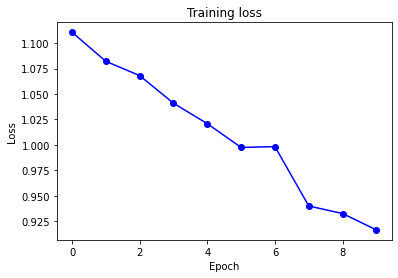

In [ ]:
import matplotlib.pyplot as plt


plt.plot(loss_val,'b-o')
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [ ]:
class CustomDataset_test(torch.utils.data.Dataset):
  def __init__(self,df,tokenizer,max_len):
    self.df = df;
    self.tokenizer = tokenizer
    self.max_len = max_len
    self.title = self.df['Tweet']
    #self.targets = self.df[target_list].values

  def __len__(self):
    return len(self.title)

  def __getitem__(self,index):
    text = (self.title.iloc[index])
    
    text = " ".join(text.split()) #return to this function 

    inputs = self.tokenizer.encode_plus(text,add_special_tokens = True,
                                  max_length=self.max_len,
                                  padding = 'max_length',
                                  return_token_type_ids = True,
                                  truncation = True,
                                  return_attention_mask = True,
                                  return_tensors = 'pt')
    
    return {
        'input_ids' : inputs['input_ids'].flatten(),
        'attention_mask' : inputs['attention_mask'].flatten(),
        'token_type_ids' : inputs['token_type_ids'].flatten()        
    }


In [ ]:
test_Data = pd.read_csv("/content/drive/MyDrive/urdu_hate_task_B/test_data.csv")
test_Data


,Tweet,Threat,S/G
0,وزیراعل ی پنجاب کا ضلع راولپنڈی کا دورہ لینڈسل...,NaN,NaN
1,الحمدلله پورے پاکستان کے وکلاء برادری کا کہنا ...,NaN,NaN
2,جنوری مہلت ختم الٹی گنتی شروع ن لیگ کے خلا...,NaN,NaN
3,کروناکی آڑ میں حکومت اورفوج جوکھیل قادیانیوں ک...,NaN,NaN
4,حکومت ایکشن میں آئے ورنہ اگر ہم ایکشن میں آگئے...,NaN,NaN
...,...,...,...
930,کوئ اور کے پیڈ جیالوں کو بتا دے عمران احمد خان...,NaN,NaN
931,مجبور نہ کرو کے لوگ قانون ہاتھ میں لیں دین اسل...,NaN,NaN
932,یہ ڈرامہ اور سیاست کریں گے یہ زلیل اور گهٹیا ل...,NaN,NaN
933,وزیراعظم صاحب آپ کا یہ اتنی جلد بازی کا فیصلہ ...,NaN,NaN


In [ ]:
model.eval()
predictions , true_labels = [] , []
tokenizer =  BertTokenizer.from_pretrained(Paths_to_transformers['mbert'])
test_dataset = CustomDataset_test(test_Data,tokenizer,128)

test_data_loader = torch.utils.data.DataLoader( test_dataset , shuffle = True  , batch_size = 16,num_workers = 2 )


for data in (test_data_loader):
  in_id = data['input_ids'].to(device,dtype = torch.long)
  at_mask = data['attention_mask'].to(device,dtype = torch.long)
  t_t_id = data['token_type_ids'].to(device,dtype = torch.long)

  with torch.no_grad():
    outputs = model(in_id,at_mask,t_t_id)
    #print(outputs)
  logits = outputs
  
  logits = torch.from_numpy(logits.detach().cpu().numpy())
  tensor = torch.nn.functional.softmax(logits,dim=-1)
  #print(tensor)
  for tens in tensor:
    #tens = [ int(prob >= 0.5) for prob in tens ]
    tens = np.argmax(tens.numpy())
    predictions.append(tens)

predictions

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bert-base-multilingual-cased/snapshots/cf732291d5a8eace7b973ccd13c95ec07b19e734/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--bert-base-multilingual-cased/snapshots/cf732291d5a8eace7b973ccd13c95ec07b19e734/tokenizer_config.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-multilingual-cased/snapshots/cf732291d5a8eace7b973ccd13c95ec07b19e734/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-multilingual-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "l

[2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,


In [ ]:

for i in range(len(test_Data)):
  test_Data['S/G'].iloc[i] = predictions[i]


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
test_Data[0]

,Tweet,Threat,S/G
0,وزیراعل ی پنجاب کا ضلع راولپنڈی کا دورہ لینڈسل...,NaN,2.0
1,الحمدلله پورے پاکستان کے وکلاء برادری کا کہنا ...,NaN,2.0
2,جنوری مہلت ختم الٹی گنتی شروع ن لیگ کے خلا...,NaN,2.0
3,کروناکی آڑ میں حکومت اورفوج جوکھیل قادیانیوں ک...,NaN,2.0
4,حکومت ایکشن میں آئے ورنہ اگر ہم ایکشن میں آگئے...,NaN,2.0
5,ہم نے مسلسل میٹنگز کیں تمام معاملات اتفاق رائ...,NaN,2.0
6,وزیراعظم صاحب ہوش کے ناخن لیں پہچانیں ان کھٹمل...,NaN,2.0
7,میڈیا کے تمام اینکرز سے گزارش جس دن سے نے کراچ...,NaN,2.0
8,زلفی بخاری قوم آپ سے حساب لے گی,NaN,2.0
9,عوام مارتی تو مر جاۓ بھاڑ میں جاۓ بھٹو کتے کا ...,NaN,2.0
